In [1]:
import pandas as pd
import requests
import re
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 1. Load and preprocess data (dev-test split) ##

In [24]:
df_raw = pd.read_excel("Independent Study Dataset.xlsx", header=None)
headers = df_raw.iloc[0]
data   = df_raw[1:].copy()
data.columns = headers

In [25]:
min_test_samples = 2
test_size = 0.4

# Ensure stratified split
train_df, test_df = train_test_split(
    data,
    test_size=test_size,
    stratify=data["Test"],
    random_state=42
)

# Check if every class has at least 2 samples in test set
counts = test_df["Test"].value_counts()
if (counts < min_test_samples).any():
    print("⚠️ Not enough samples per class in test set.")

# Save splits
train_df.to_csv("outputs/dev_set.csv", index=False)
test_df.to_csv("outputs/test_set.csv", index=False)

print("Test set distribution:\n", test_df["Test"].value_counts())

Test set distribution:
 Test
logistic regression           5
anova                         5
two-sample t-test             5
paired t-test                 4
one-sample t-test             4
chi-square test               4
multiple linear regression    4
Name: count, dtype: int64


## 2. Llama Workflow (baseline) ##

In [39]:
API_BASE = "http://localhost:1234/v1"
# MODEL    = "meta-llama-3.1-8b-instruct"
MODEL    = "llama-3.2-3b-instruct"

In [40]:
# Function to answer a question using the LLaMA model (sent throught LMStudio API)
def answer_question(scenario):
    # Construct prompt
    prompt_lines = [
        "You are a helpful assistant that suggests statistical test based on provided research scenario.",
        "TASK: Given the following research scenario, suggest the most appropriate statistical test. The test must be one of the following: one-sample t-test, two-sample t-test, ANOVA, Chi-square test, paired t-test, multiple linear regression, logistic regression.",
        f"SCENARIO: {scenario}",
        "NOTE: Your response should include consideration of assumptions and conditions for each test.",
        "Show your step-by-step reasoning and then on its own line, output exactly: 'Final Answer: <test name>'.",
    ]
    prompt = "\n".join(prompt_lines)

    # Call model via API
    payload = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
    }
    resp = requests.post(
        f"{API_BASE}/chat/completions",
        json=payload,
        headers={"Content-Type": "application/json"}
    )
    resp.raise_for_status()
    raw = resp.json()["choices"][0]["message"]["content"].strip()

    # Extract final answer using regex
    match = re.search(r"Final Answer:\s*(.*)", raw)
    if match:
        test_name = match.group(1).strip()
        test_name = re.sub(r"[\*\.]+$", "", test_name)
        test_name = re.sub(r"^[\s\*'\"]+", "", test_name)
        test_name = test_name.lower()
    else:
        test_name = "Unknown"
        print("Warning: 'Final Answer' not found in the model's response.")

    return raw, test_name

In [41]:
# Loop over each scenario and get model's answer
data = pd.read_csv("outputs/dev_set.csv")

results = []

for idx, row in data.iterrows():
    scenario   = row["Scenario"]
    true_label = row["Test"]

    justification, model_answer = answer_question(scenario)

    results.append({
        "Scenario": scenario,
        "True_Answer": true_label,
        "Model_Justification": justification,
        "Model_Answer": model_answer
    })

# Save results
out_df = pd.DataFrame(results)
out_path = "outputs/dev_results_llama_3B.csv"
out_df.to_csv(out_path, index=False)

print("Saved results to ", out_path)

Saved results to  outputs/dev_results_llama_3B.csv


Overall Accuracy: 58.70%

Per-Class Performance:
                                  precision    recall  f1-score   support

    analysis of variance (anova)      0.000     0.000     0.000         0
                           anova      0.750     0.857     0.800         7
                 chi-square test      0.500     0.833     0.625         6
                          f-test      0.000     0.000     0.000         0
f-test for equality of variances      0.000     0.000     0.000         0
             logistic regression      0.000     0.000     0.000         6
      multiple linear regression      1.000     0.833     0.909         6
               one-sample t-test      1.000     0.714     0.833         7
                   paired t-test      0.750     0.429     0.545         7
               two-sample t-test      0.333     0.429     0.375         7
       wilcoxon signed-rank test      0.000     0.000     0.000         0

                        accuracy                          0.5

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


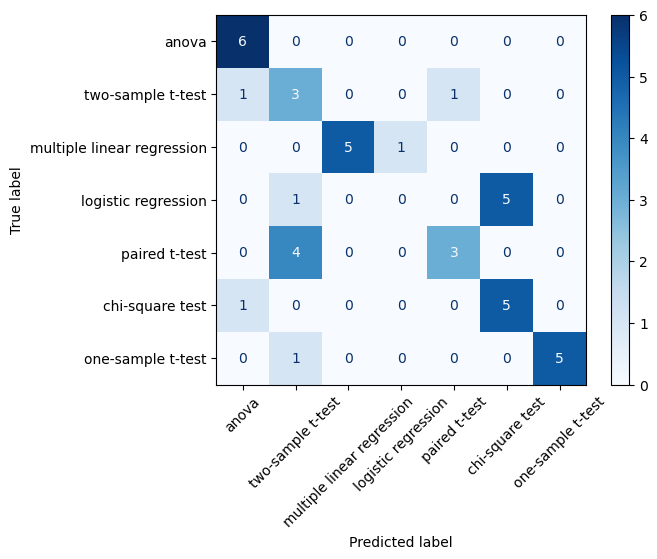

In [42]:
# Result evaluation (3B)

df = pd.read_csv("outputs/dev_results_llama_3B.csv")
df["True_Answer"] = df["True_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)
df["Model_Answer"] = df["Model_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

Overall Accuracy: 86.96%

Per-Class Performance:
                            precision    recall  f1-score   support

                     anova      0.875     1.000     0.933         7
           chi-square test      0.750     1.000     0.857         6
       logistic regression      1.000     0.667     0.800         6
multiple linear regression      1.000     1.000     1.000         6
         one-sample t-test      1.000     0.857     0.923         7
             paired t-test      0.857     0.857     0.857         7
         two-sample t-test      0.714     0.714     0.714         7

                  accuracy                          0.870        46
                 macro avg      0.885     0.871     0.869        46
              weighted avg      0.883     0.870     0.868        46



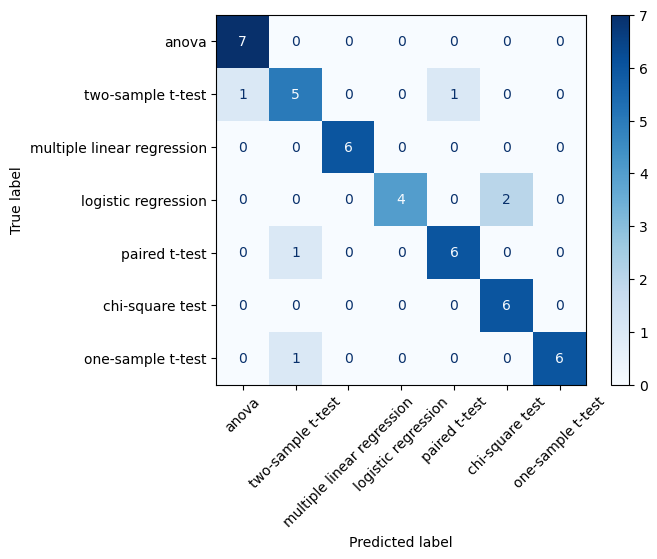

In [ ]:
# Result evaluation (8B)

df = pd.read_csv("outputs/dev_results_llama_8B.csv")
df["True_Answer"] = df["True_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)
df["Model_Answer"] = df["Model_Answer"].str.lower().str.replace(r"[\*\.]+$", "", regex=True)

# Overall accuracy
overall_acc = accuracy_score(df["True_Answer"], df["Model_Answer"])
print(f"Overall Accuracy: {overall_acc:.2%}")

# Accuracy per class
print("\nPer-Class Performance:")
print(classification_report(df["True_Answer"], df["Model_Answer"], digits=3))

# Confusion matrix
cm = confusion_matrix(df["True_Answer"], df["Model_Answer"], labels=df["True_Answer"].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df["True_Answer"].unique())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()